# EN4353 - Radar & Navigation

### Assignment 01

##### Name: S.Sooriyakumar
##### Index No: 170599G
##### Department : E.N.T.C
##### Batch : 17th

##### Step1: Get the code & files

GUI method : Download this github repo as a zipfile

or

CLI method : git clone https://github.com/Sooriyakumar23/EN4353-Radar-Navigation.git

##### Step2:

1. Navigate to this repo
2. Open anaconda prompt in this folder
2. Type "jupyter notebook"
3. Open the jupyter notebook file named as "EN4353-Assignment01.ipynb"

##### Step3: Run this jupyter notebook script : csv file => Cloud Detection

##### Step3.1: Load libraries & Dataset 

In [2]:
##### 0. To check the files in the folder

!dir

 Volume in drive D is New Volume
 Volume Serial Number is 6A37-1716

 Directory of D:\SEM-8\Radar\Assignment-01

03/06/2022  06:49 PM    <DIR>          .
03/06/2022  06:49 PM    <DIR>          ..
03/06/2022  04:17 PM    <DIR>          .ipynb_checkpoints
03/06/2022  06:49 PM           429,668 EN4353-Assignment01.ipynb
02/14/2022  02:44 PM           285,213 EN4353_Radar_and_Navigation_Assignment_1.pdf
12/15/2020  11:59 AM           476,240 raw_data1.csv
12/09/2020  01:26 PM           476,064 raw_data2.csv
12/09/2020  01:26 PM           475,814 raw_data3.csv
03/06/2022  04:18 PM             3,304 samplesssss.ipynb
               6 File(s)      2,146,303 bytes
               3 Dir(s)  449,107,701,760 bytes free


In [176]:
##### 1. Importing necessary libraries

import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

In [4]:
##### 2. Getting all the dataset files which are in local

csvFiles = glob.glob("*.csv")

print ("Dataset files are", csvFiles)

Dataset files are ['raw_data1.csv', 'raw_data2.csv', 'raw_data3.csv']


In [107]:
##### 3. Loading preferred csv dataset file

# Format of the input is only the csv file name without extension
# eg:- raw_data1
datasetFileName = input("Enter one of the above csv data file to load and proceed: ")

try:
    dataset = numpy.genfromtxt(datasetFileName+".csv")
    print (f"\n{datasetFileName}.csv loaded as 'dataset' variable")
except :
    print ("\nIncorrect file name inputted...!")

Enter one of the above csv data file to load and proceed: raw_data1

raw_data1.csv loaded as 'dataset' variable


##### Step3.2: Visualize and preprocess dataset 

In [6]:
print ("Dataset size is", dataset.size)

Dataset size is 18000


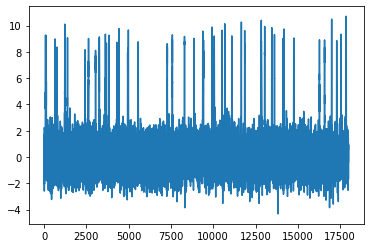

In [7]:
# Just plotting the points in the datasets

plt.plot(dataset)

##### Step3.3: Assigning parameters to variables  

In [93]:
videoSamplingRate = 1080*1000 # Video sampling frequency
repetitionFrequency = 1800 # Pulse repetition frequency
rangeSlot = 30 # Number of range slots
windowSize = 21 # <- Threshold Detection
guardBand = 4 # <- Determine Average Noise Voltage
halfSlot = rangeSlot//2 # <- Coherent Detection

k = 1.3 # <- Noise Thresholding
sigmaN = 1 # <- Noise Thresholding

initialAzimuthAngle = 0 # (Degree)
horizontalBeamAngle = 2 # (Degree)
rotationSpeed = 12 # Radar rotational speed in R.P.M
lightSpeed = 3e+8 # Light speed in air

##### Step3.4: Analog to Digital Conversion (ADC) 

* Sampling frequency = Number of range slots x Repetition frequency

* Sampling time period = Inverse of sampling frequency

* Sampled time period = Number of samples / Sampling frequency

* Revolved angle = Rotation speed x Sampled time period 360 degrees / 60

* Echoes per horizontal beam angle = Horizontal beam angle * Repetition frequency / (6 x Rotation speed)

* Echoes for revolved angle = (Echoes per horizontal beam angle x Revolved angle) / Horizontal beam angle



3.4.1. Down sampling

In [108]:
samplingFrequency = rangeSlot * repetitionFrequency
samplingTime = videoSamplingRate / samplingFrequency
length = len(dataset)
numberOfSamples = int(length / samplingTime)
matrix = dataset.reshape(numberOfSamples,int(samplingTime))
sampledTime = numberOfSamples / samplingFrequency
revolvedAngle = rotationSpeed * length * 360 / (60 * videoSamplingRate)
echoesPerHBW = (horizontalBeamAngle * repetitionFrequency) / (6 * rotationSpeed)
numberOfEchoes = int((echoesPerHBW * revolvedAngle)/horizontalBeamAngle)

matrix_sampled = matrix[:, 0].reshape(numberOfEchoes, rangeSlot) 

3.4.2. Visualize Data Matrix

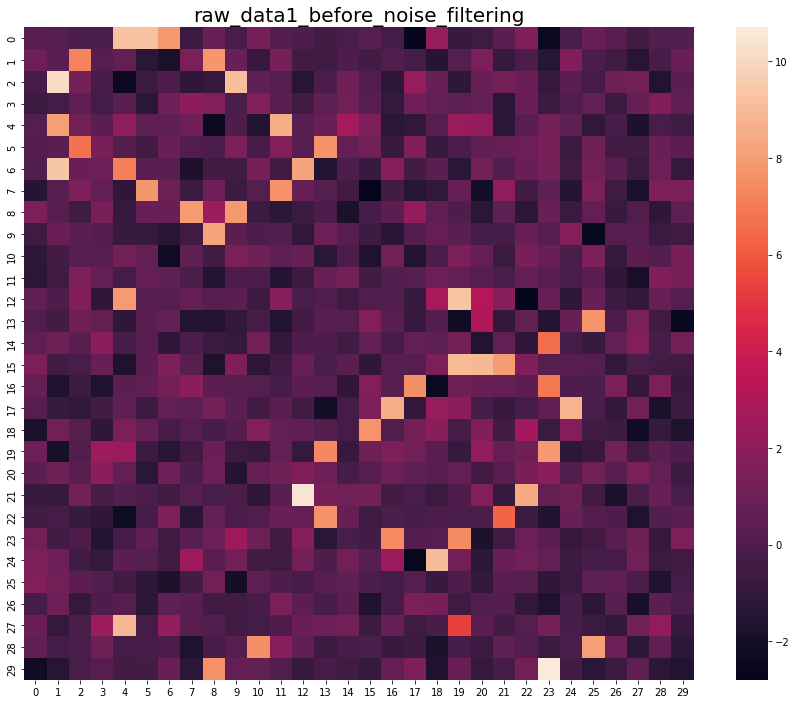

In [117]:
plt.figure(figsize=(15, 12))
plt.title(f"{datasetFileName}_before_noise_filtering", fontsize=20)
hm = sns.heatmap(matrix_sampled)
plt.savefig(f"{datasetFileName}_before_noise_filtering.png")

##### Step3.5: Noise threshold calculation  

3.5.1. Noise average formula

Window size = 21 ;

Number of samples in past = 6,

Number of guard samples in past = 4, 

Number of guard samples in present = 4, 

Number of samples in present = 6.

Average Noise = $\frac{\sum _{i-=5} ^{i-=10} (samples) + \sum _{i+=5} ^{i+=10} (samples)}{12}$

Threshold = Average Noise + k . $\sigma_n$

3.5.2. Noise average calculation

In [127]:
def AverageNoise(matrix, k, sigmaN):
    future = matrix[:, 5:11]
    temporary = matrix[:numberOfSamples-1, 10:16]
    past = np.vstack([future[0], temporary])
    averageNoise = np.mean(np.concatenate((future, past), axis=1), axis=1)
    threshold = averageNoise + k * sigmaN
    return (threshold)

In [132]:
threshold = AverageNoise(matrix, k, sigmaN).reshape(numberOfEchoes, rangeSlot)

3.5.3. Visualization of noise threshold

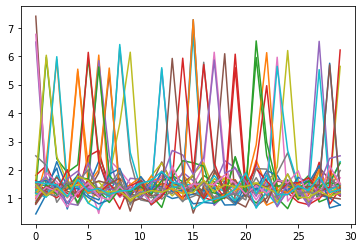

In [133]:
plt.plot(threshold)

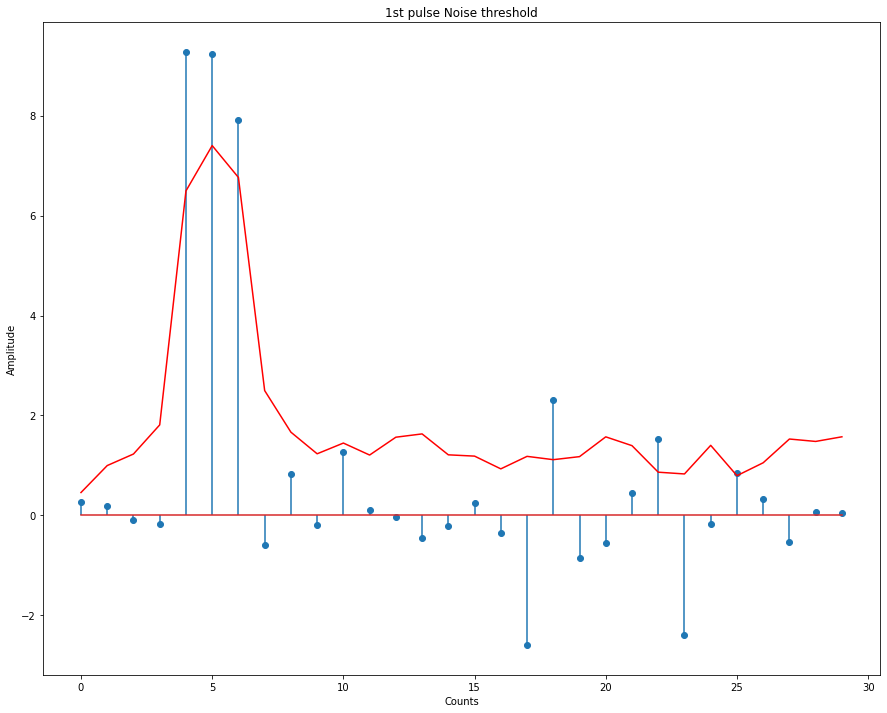

In [144]:
plt.figure(figsize=(15, 12))
plt.stem(matrix_sampled[0,0:30],use_line_collection=True)
plt.plot(threshold[0,0:30],color='r')
plt.ylabel('Amplitude')
plt.xlabel('Counts')
plt.title('1st pulse Noise threshold')
plt.savefig('Noise threshold detect.png')

##### Step3.5: Threshold detection

Amplitude > Threshold => Amplitude :- 1

Amplitude = Threshold => Amplitude :- 0

Amplitude < Threshold => Amplitude :- 0

In [149]:
def Threshold(matrix_sampled, threshold):
    return (matrix_sampled > threshold)*1

In [150]:
data = Threshold(matrix_sampled, threshold)

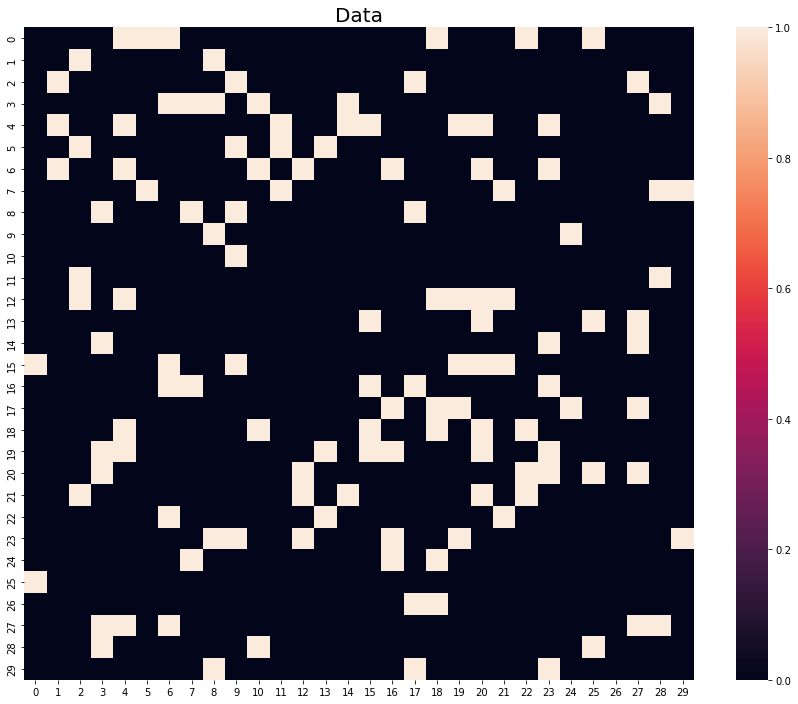

In [162]:
plt.figure(figsize=(15, 12))
plt.title("Data", fontsize=20)
sns.heatmap(data)
plt.savefig("Data.png")

##### Step3.5: Post detection integration 

count > 0.5 :- Target in that range

According to instructions, column that representing target = 0.5

In [160]:
def PostDetection(data, value):
    floatingData = data.astype(np.float)
    sumRange = np.sum(floatingData, axis=0)
    detections = []
    for i, j in enumerate(sumRange):
        if j >= value:
            detections.append(i)
            floatingData[:, i] = 0.5
    return (floatingData, detections)

In [161]:
floatingData, detections = PostDetection(data, 15)

C:\Users\Soori\AppData\Local\Temp/ipykernel_15428/3283106329.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  floatingData = data.astype(np.float)


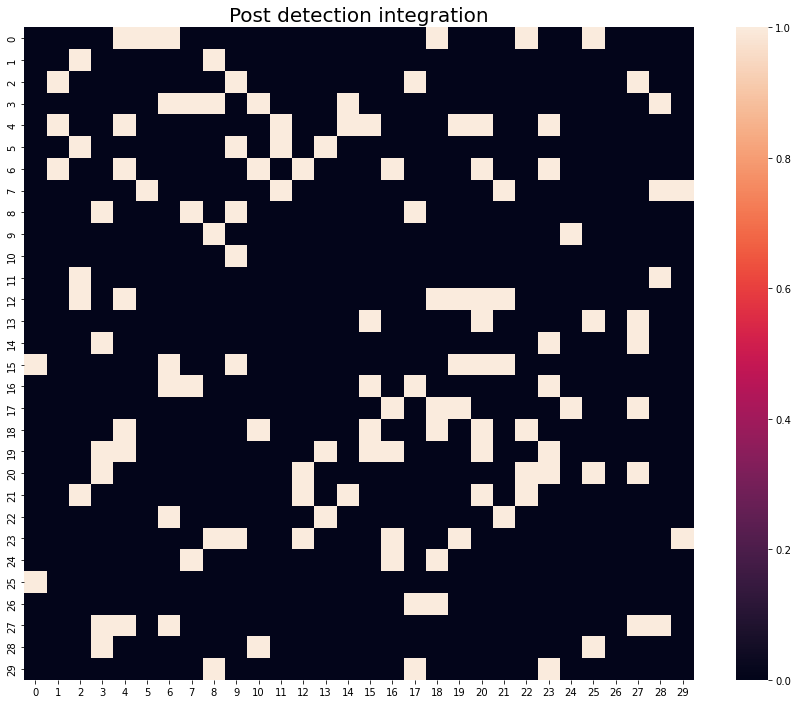

In [163]:
plt.figure(figsize=(15, 12))
plt.title("Post detection integration", fontsize=20)
sns.heatmap(floatingData)
plt.savefig("Post Detected Data.png")

##### Step3.6: Cloud detection  

Step 3.6.1: Thresholding 

1. Amplitude < Threshold :- Amplitude = 0
2. Amplitude < 6 :- AMplitude = 0
3. Normalize values in the matrix and map all non zero values to 1 and zero range slots with objects.

In [167]:
#apply thresholding step1
Radar_filtered = (np.where(matrix_sampled > threshold, matrix_sampled,0)/1).reshape(no_echos,N)

#appply thresholding step2
Radar_filtered1 = np.where(Radar_filtered>6,Radar_filtered,0)

#appply thresholding step3
Radar_filtered2 = Radar_filtered1/np.max(Radar_filtered1)

#convert image to binary and remove objects
Radar_binary = np.where(Radar_filtered2>0,1,0)
Radar_binary[:,detections] = 0

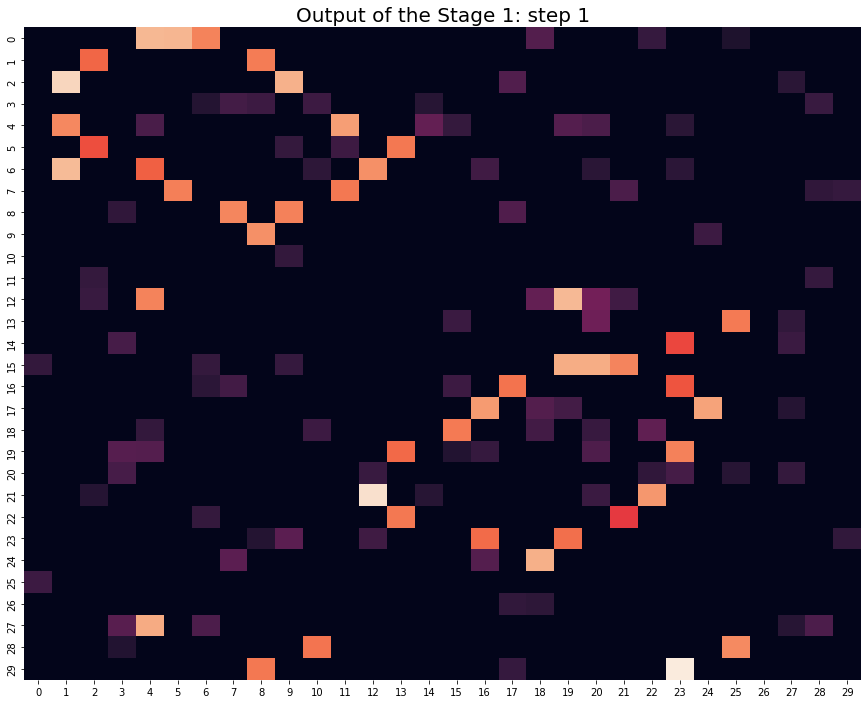

In [170]:
plt.figure(figsize=(15, 12))
plt.title('Output of the Stage 1: step 1',fontsize = 20)
ax = sns.heatmap(Radar_filtered.reshape(numberOfEchoes,rangeSlot),cbar=False)

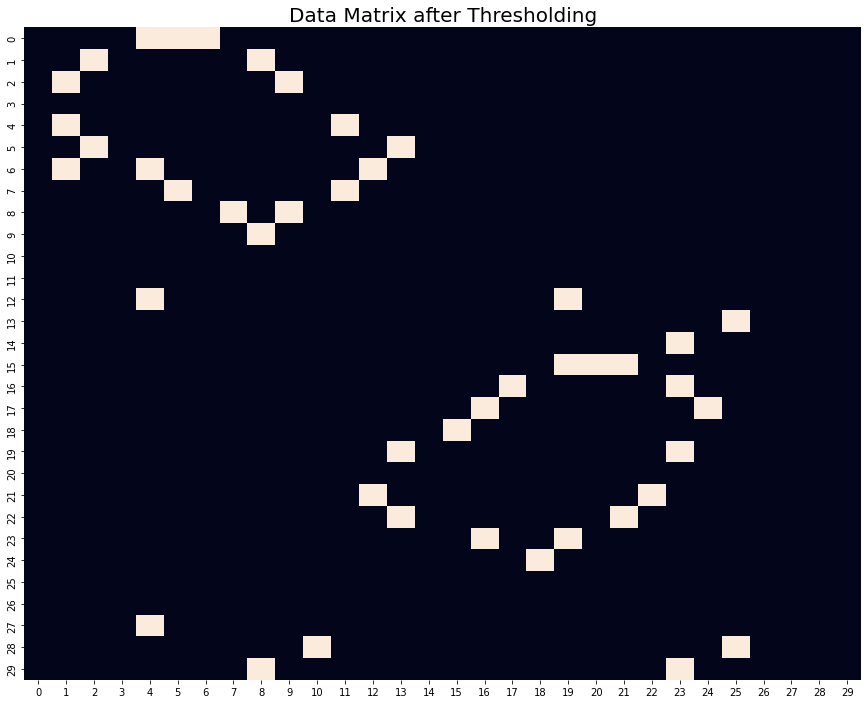

In [171]:
#remove object responses
plt.figure(figsize=(15, 12))
plt.title('Data Matrix after Thresholding',fontsize = 20)
ax = sns.heatmap(Radar_binary.reshape(numberOfEchoes,rangeSlot),cbar=False)

Step 3.6.2: Filtering

1. Apply noise reduction filter with 7x7 kernel with  3 as threshold value
2. Apply noise reduction filter with 5x5 kernel with  2 as threshold value

In [172]:
#noise reduction function
def noise_reduction(matrix,kernel_offset,threshold):
  h,w = matrix.shape

  for i in range (0+kernel_offset,h-kernel_offset):
    for j in range (0+kernel_offset,w-kernel_offset):
      kernel = matrix[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1]
      if matrix[i,j]: 
        sum = np.sum(kernel)
        if sum < threshold:
          matrix[i:min(i-2,i),j:min(i-2,i)] = 0
          matrix[i-(kernel_offset-1):i+(kernel_offset),j-(kernel_offset-1):j+(kernel_offset)] = 0
  return matrix

def noise_1D (matrix,kernel_offset,threshold):
  h,w = matrix.shape

  rows_0 = matrix[0,:]
  rows_1 = matrix[h-1,:]

  col_0 = matrix[:,0]
  col_1 = matrix[:,w-1]

  for i in range (0,w-kernel_offset):
    kernel = rows_0 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      rows_0[i]=0

  for i in range (0,w-kernel_offset):
    kernel = rows_1 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      rows_1[i]=0

  for i in range (0,h-kernel_offset):
    kernel = col_0 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      col_0[i]=0
  for i in range (0,h-kernel_offset):
    kernel = col_1 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      col_1[i]=0
  return matrix

#apply noise filters
interm_noisy = noise_reduction(Radar_binary.reshape(no_echos,N),3,3)
binary_filtered = noise_reduction(interm_noisy.reshape(no_echos,N),2,2)

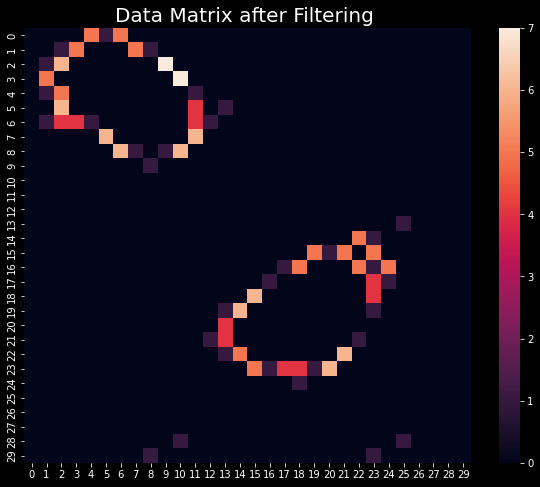

In [184]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Filtering ',fontsize = 20)
ax = sns.heatmap(binary_filtered)

Step 3.6.3: Complete Missing Values

1. Fill gaps with 2 empty cells
2. Apply noise reduction filter with 5x5 kernel with 4 as threshold value
3. Fill gaps with 1 empty cells
4. Apply noise reduction filter with 3x3 kernel with  2 as threshold value

In [174]:
#fill max distance == 2 

def fill_two(kernel):
  def filter(kernel):

    for i in range (4):
        if  (kernel[i,0] ==1 and kernel[i,3]==1) : 
          # print('0***')
          kernel[i,1:3] = 4 
        elif (i<3) and (kernel[i,0] ==1 and kernel[i+1,3]==1) :
          # print('*0**')
          kernel[i,1] = 5
          kernel[i+1,2]=5
        elif (i<2) and (kernel[i,0] ==1 and kernel[i+2,3]==1) :
          # print('**0*')
          kernel[i+1,1] = 6
          kernel[i+2,2]=6
        elif (i<1) and (kernel[i,0] ==1 and kernel[i+3,3]==1) :
          # print('***0')
          kernel[i+1,1] = 7
          kernel[i+2,2]=7

    return kernel 


  return filter(kernel)

# fill max distance =1

def fill_ones(kernel):

    if (kernel[0,0] == 1 and kernel[2,2] == 1) or (kernel[0,2] == 1 and kernel[2,0] == 1)  or (kernel[1,0] == 1 and kernel[1,2] == 1) or (kernel[0,1] == 1 and kernel[2,1] == 1): 
      kernel[1,1] = 2

    elif (kernel[0,0] == 1 and (kernel[2,1] == 1 or kernel[1,2] == 1)) and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[0,2] == 1 and (kernel[1,0] == 1 or kernel[2,1] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,0] == 1 and (kernel[0,1] == 1 or kernel[1,2] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,2] == 1 and (kernel[1,0] == 1 or kernel[0,1] == 1))and (3 not in kernel): kernel[1,1] = 3   

    return kernel


def draw_lines2 (AAA):
  h,w = AAA.shape
  kernel_offset = 3
  for i in range (0,h-kernel_offset):
    for j in range (0,w- kernel_offset):
      kernel = AAA[i:i+kernel_offset+1,j:j+kernel_offset+1]

      CCC = fill_two(kernel)
      DDD =  np.flip(fill_two(np.flip(CCC,axis=1)),axis=1)
      AAA[i:i+kernel_offset+1,j:j+kernel_offset+1] = np.transpose(fill_two(np.transpose(DDD)))
  return AAA

def draw_lines1 (AAA):
  h,w = AAA.shape
  kernel_offset = 4
  for i in range (0+kernel_offset,h-kernel_offset):
    for j in range (0+kernel_offset,w-kernel_offset):
      kernel = AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1]
      if np.sum(kernel)<5:
        BBB = fill_ones(kernel)
        AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1] = BBB

  return AAA

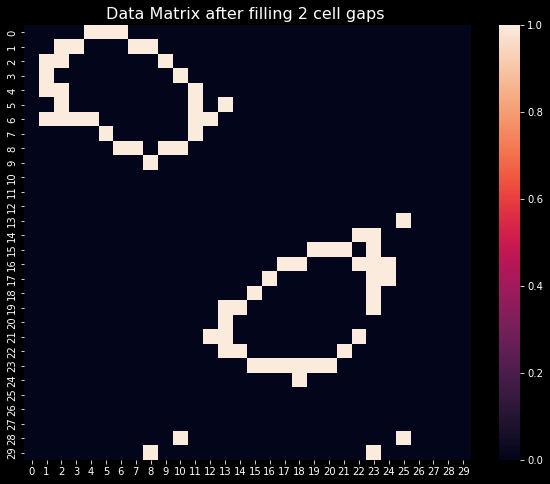

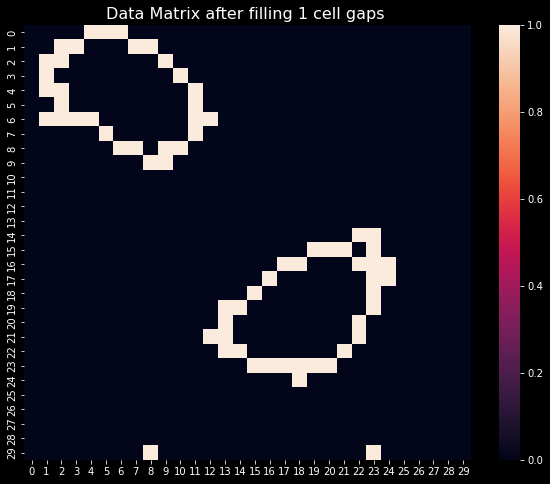

In [193]:
#fill 2 blanks
draw_2 =(draw_lines2 (binary_filtered)>0)*1

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after filling 2 cell gaps ',fontsize = 16)
ax = sns.heatmap(draw_2)

#noise filter
draw2_filt= noise_reduction(draw_2,2,4)

#fill 1 blank
draw_1 =(draw_lines1 (draw2_filt)>0)*1

draw1_filt= noise_reduction(draw_1,1,3)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after filling 1 cell gaps ',fontsize = 16)
ax = sns.heatmap(draw_1)

Step 3.6.4: Fill Cloud Contour

1. Use floodfill algorithm to fill cloud cointour within cloud boundary
2. Apply noise reduction filters to edge rows and columns with 3x3 kernel with 2 as threshold.

In [177]:
data_matrix_uint=draw_1.astype(np.uint8)
floodFill=cv.floodFill(data_matrix_uint, None, seedPoint=(0,0), newVal=5)

matrix_ret=floodFill[1].reshape(no_echos,N)
dataMtrix_processed = np.where(matrix_ret==5,0,1)

C:\Users\Soori\AppData\Local\Temp/ipykernel_15428/2664960448.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataMatrix_final=noise_1D (dataMtrix_processed,3,2).astype(np.float)


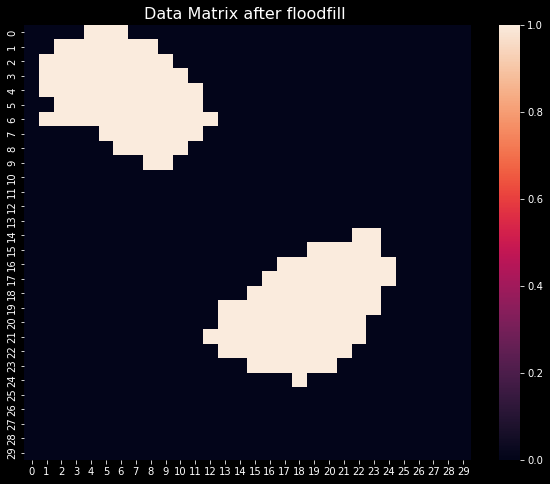

In [186]:
dataMatrix_final=noise_1D (dataMtrix_processed,3,2).astype(np.float)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after floodfill ',fontsize = 16)
ax = sns.heatmap(dataMatrix_final)

##### Step3.7: Visualization of Clouds & Targets

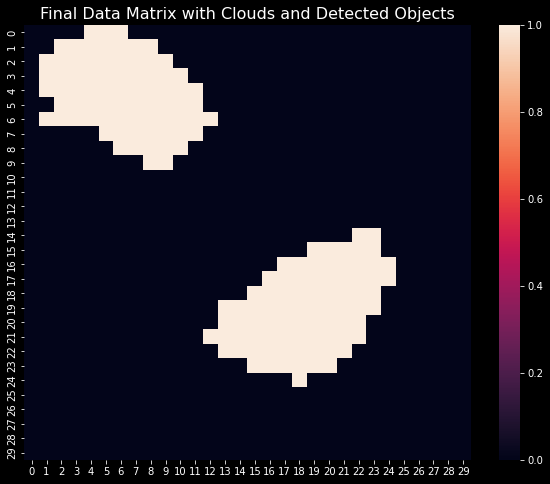

In [188]:
#add object columns
dataMatrix_final[:,detections]=0.5

f, ax = plt.subplots(figsize=(10,8))
plt.title('Final Data Matrix with Clouds and Detected Objects',fontsize = 16)
ax = sns.heatmap(dataMatrix_final)

In [189]:
if len(detections) != 0:
  k = (rev_speed*360/60) * (1/(2*Fs))

  azymuth = np.dot(detections,0)
  range_m = np.dot(C/(2*Fs),np.add(detections,1))

  for i,(r, theta) in enumerate(zip(range_m, azymuth)):
    print(f'Target {i} is at ({r*1e-3:.3f}km, {theta:.3f}deg)')
else:
  print('No target detected')
  azymuth = []
  range_m = []

No target detected


In [190]:
#plot target vectors in radar screen

def plot_point(angle, length_m):
  norm_fact  = N * (C/2) * (1/(fr * N) )
  
  if len(length_m) !=0:
    length = length_m/1000
  else:
    length = length_m
  fig = plt.figure(figsize=(8,8))
  plt.style.use('dark_background')
  x, y = (0,0)                                                                    
  font_dict = {'size':'12', 'color':'xkcd:chartreuse'}
  n_target = 1
  plt.polar()   
  fig.set_facecolor('xkcd:black')                                                                
  if len(angle) == 0:                                                             
    plt.text(0, 0,'x' , font_dict)

  for az_angle, range_val in zip(angle, length):
    plt.polar(az_angle, range_val, 'ro', markersize=10)                           
    str_ = f'T:0{n_target}\n({range_val:.2f}km, {az_angle:.2f} deg)'
    plt.text(az_angle - 0.05, range_val+0.05, str_, font_dict)                    
    n_target += 1

  plt.title('Radar Screen', {'size':'16', 'color':'xkcd:chartreuse', 'weight':'normal',
          'verticalalignment':'bottom'})
  fig.show()

C:\Users\Soori\AppData\Local\Temp/ipykernel_15428/3063492121.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


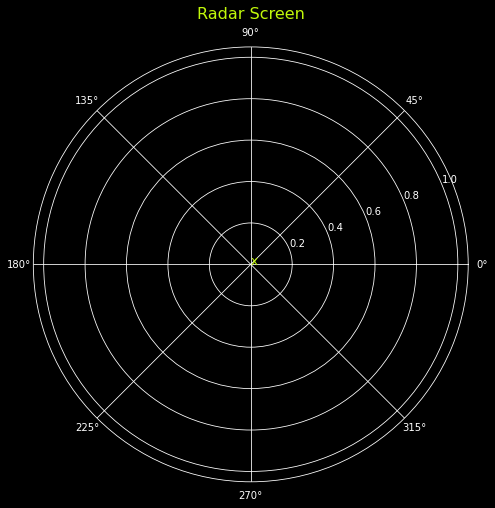

In [191]:
ax=plot_point(azymuth,range_m)